# IMRT fluence maps and the power of transfer learning

The goal of this notebook is to predict gamma index values of calculated fluence maps in IMRT.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models # from torchvision.models import *    # import *=all the models from torchvision
import random

print(f"pytorch version = {torch.__version__}")
print(f"torchvision version = {torchvision.__version__}")

pytorch version = 1.6.0
torchvision version = 0.7.0


In [2]:
import cv2
import matplotlib.pyplot as plt

## Data

Fluence maps are read from JPEG files, which are generated from DICOM files in RT Dose format, using __fluence_maps/util/dicom2jpeg.py__

In [3]:
np.random.seed(34567)
PATH = Path("/home/pablo/datasets/data/radioterapia/ciolaplata/")

# CODEX_FILE = "codex.2018-2019.csv" # mapas 3mm/3% con doseshift años 2018 y 2019
# CODEX_FILE = "codex-2019-3mm3%-doseshift.csv" # mapas 3mm/3% con doseshift año 2019
# CODEX_FILE = "codex-2019-2mm2%-doseshift.csv" # mapas 2mm/2% con doseshift año 2019
CODEX_FILE = "codex-2019-3mm3%-doseshift-TR40%.csv" # mapas con ajuste tolerancia 40%

MAPS_LOCATION_SUFFIX = "-opencv-jpeg"
path = PATH/Path("2018" + MAPS_LOCATION_SUFFIX)
path2 = PATH/Path("2019" + MAPS_LOCATION_SUFFIX)

# list_all = list(path.iterdir())+list(path2.iterdir())
list_all = list(path2.iterdir())
random.shuffle(list_all)
list_all[:10]

[PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.99457751512453912440684376613416717218.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.202990697011124929619203800620479269104.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.60285312311703657337041642833980028906.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.29312458711226660817070993270548923877.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.312544516811084421009349364993808409141.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.81492291512482675003315795711373693896.jpeg'),
 PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return im

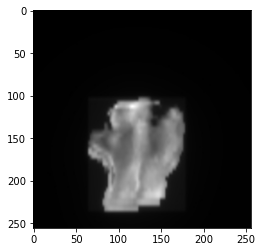

In [5]:
path = PATH/Path("2018" + MAPS_LOCATION_SUFFIX)/"1.3.6.1.4.1.9590.100.1.2.310116611339769406079254153056253359.jpeg"
im = read_image(path)
plt.imshow(im)

In [6]:
im = cv2.imread(str(path))
im.shape

(256, 256, 3)

In [7]:
# let's look at the typical size of these images
files = list_all[:1000]
dims = [read_image(str(p)).shape for p in files]

In [8]:
np.unique(dims)

array([  3, 256])

Amazing! all images have the same size.

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification task

Pablo:
1. Data augmentation can be enabled when creating the dataset, ex.: train_ds = FluenceMapsDataset(train_maps, transform=TRANSFORM)
2. Data augmentation did not improve MAE in validation. As with no data augmentation, overfitting is very small when data augmentation is used, but the problem is not overfitting but underfitting, i.e. performance in training is not good.

In [9]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

(240, 240, 3)

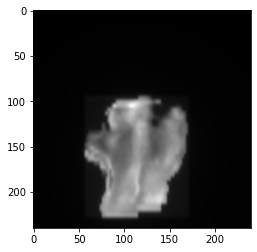

In [10]:
path = PATH/Path("2018" + MAPS_LOCATION_SUFFIX)/"1.3.6.1.4.1.9590.100.1.2.310116611339769406079254153056253359.jpeg"
im = read_image(path)
im_c = center_crop(im)
plt.imshow(im_c) # plt.imshow(im_c, cmap='gray') is the same
im_c.shape

### Resize, horizontal and vertical translations

(256, 256, 3)

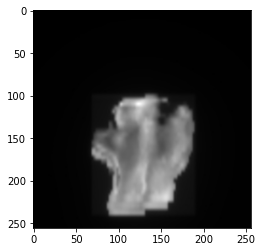

In [11]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
# Pablo: but I am not resizing to a larger size but to original size 256x256
im_l = cv2.resize(im, (272, 272))
im_l = random_crop(im_l)
plt.imshow(im_l)
im_l.shape

### Translation

In [12]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/
# py_geometric_transformations.html
def random_translation(x, t_pix=8):
    """ Returns a random translation"""
    rows, cols, *_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    t_r = np.floor(rand_r*t_pix).astype(int)
    t_c = np.floor(rand_c*t_pix).astype(int)
    # shift (t_r, t_c)
    T = np.float32([[1, 0, t_r], [0, 1, t_c]]) 
    # We use warpAffine to transform the image using the matrix T 
    return cv2.warpAffine(x, T, (cols, rows)), T

[[1. 0. 0.]
 [0. 1. 3.]]


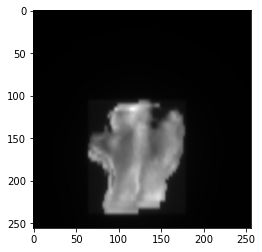

In [13]:
im_translation, T = random_translation(im)
print(T)
plt.imshow(im_translation) 

### Random Rotation (-10, 10) 

0.8457804923896206


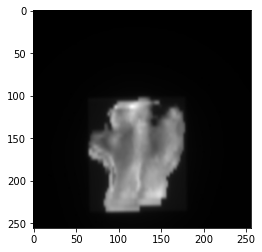

In [14]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

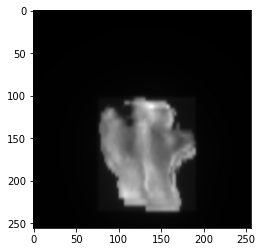

In [15]:
im_f = np.fliplr(im)
plt.imshow(im_f)

## Split train and validation

_Pablo: Not all fluence map files have a gamma value in the gamma .csv file, so we need to split the gamma .csv file and not the map files in the file system._

In [16]:
# from sklearn.model_selection import train_test_split
# all_files = list(PATH.iterdir())
# X_train, X_test = train_test_split(all_files, test_size=0.2, random_state=12345)

In [17]:
# print(len(X_train), len(X_test))

In [18]:
maps_in = pd.read_csv(PATH/CODEX_FILE, sep=';', delimiter=None, header=0)
maps_in.head()

,año,fluencia medida,fluencia calculada,uno menos gamma index
0,2019,1.3.6.1.4.1.9590.100.1.2.106363004312018285639...,1.3.6.1.4.1.9590.100.1.2.250681179813913418312...,0.013431
1,2019,1.3.6.1.4.1.9590.100.1.2.117111588412865729801...,1.3.6.1.4.1.9590.100.1.2.189485955411711008602...,0.013570
2,2019,1.3.6.1.4.1.9590.100.1.2.190727149413805451333...,1.3.6.1.4.1.9590.100.1.2.266447459412025533907...,3.115100
3,2019,1.3.6.1.4.1.9590.100.1.2.211756715011326913522...,1.3.6.1.4.1.9590.100.1.2.310552899912770926928...,0.000000
4,2019,1.3.6.1.4.1.9590.100.1.2.225990696211768600614...,1.3.6.1.4.1.9590.100.1.2.384142289612482598518...,0.355200


In [19]:
maps_out = pd.DataFrame(columns=['full_filename_jpeg', 'gamma_index'])
maps_out['full_filename_jpeg'] = [PATH/Path(str(row[0])+MAPS_LOCATION_SUFFIX)/Path(str(row[1])+'.jpeg') for row in maps_in[['año', 'fluencia calculada']].values]
maps_out['gamma_index'] = maps_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)
maps_out.head()

,full_filename_jpeg,gamma_index
0,/home/pablo/datasets/data/radioterapia/ciolapl...,99.986569
1,/home/pablo/datasets/data/radioterapia/ciolapl...,99.986430
2,/home/pablo/datasets/data/radioterapia/ciolapl...,96.884900
3,/home/pablo/datasets/data/radioterapia/ciolapl...,100.000000
4,/home/pablo/datasets/data/radioterapia/ciolapl...,99.644800


In [20]:
maps_out['full_filename_jpeg'][0], maps_out['gamma_index'][0]

(PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.986569)

In [21]:
row = maps_out.iloc[0,:]
row['full_filename_jpeg'], row['gamma_index'] 

(PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.986569)

In [22]:
y = row['gamma_index']
y, type(y), y[None], type(y[None]), y[None][0], type(y[None][0])

(99.986569,
 numpy.float64,
 array([99.986569]),
 numpy.ndarray,
 99.986569,
 numpy.float64)

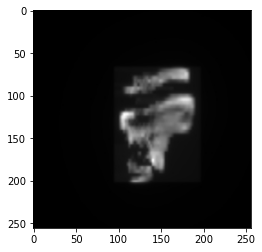

In [23]:
path = row['full_filename_jpeg']
im = read_image(path)
plt.imshow(im)

In [24]:
im.shape

(256, 256, 3)

In [25]:
# channel 0
np.min(im[:,:,0]), np.max(im[:,:,0])

(0, 255)

In [26]:
mask = np.random.random(len(maps_out)) < 0.8
train_maps = maps_out[mask].copy()
valid_maps = maps_out[~mask].copy()

In [27]:
len(maps_out), len(train_maps), len(valid_maps) 

(1230, 982, 248)

In [28]:
files = [x for x in maps_out['full_filename_jpeg']]
files = list(set(files)) # set(.) to remove duplicates
len(files)

1229

## Resizing data

In [29]:
# 272 = 256 (orig size) + 8*2 (8 pixels cropped)
def resize_crop_image(path, sz=(272, 272)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

In [30]:
def resize_all_images(resize_path):
    files = [x for x in train_maps['full_filename_jpeg']]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
            
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [31]:
TRANSFORM = False
# Uncomment to do random cropping as part of data augmentation
#
#if TRANSFORM:
#    RESIZE_PATH = 'train_272_272'
#    # just run the first time
#    resize_all_images(PATH/RESIZE_PATH)
#
#    train_maps['full_filename_jpeg'] = Path('/').joinpath(*(file.parts[:-2]+(RESIZE_PATH,)+(file.parts[-1],)))
#    train_maps.head()

## Dataset

In [32]:
train_maps['full_filename_jpeg'][0], train_maps['gamma_index'][0]

(PosixPath('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.986569)

In [33]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    """
    # Image must be casted to float32 first
    image = image.astype('float')
    image = (image/255.0)
    return image

In [34]:
def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    """
    # Image must be casted to float32 first
    image = image.astype('float')
    # Rescale image from [0, 255] to [0, 2], and by substracting -1 we rescale to [-1, 1].
    image = (image/127.5) - 1
    return image

In [35]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    imagenet_stats = np.array([mean, std])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [36]:
class FluenceMapsDataset(Dataset):
    def __init__(self, maps, transform=False):
        self.num_maps = len(maps)
        self.maps = maps
        self.transform = transform
        
    def __len__(self):
        return self.num_maps
    
    def __getitem__(self, index):
        row = self.maps.iloc[index,:]
        y = row['gamma_index']
        path = str(row['full_filename_jpeg'])
        x = read_image(path)
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            # x = random_crop(x)
            # if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x, _ = random_translation(x)
        x = rescale_0_to_1(x)
        # x = normalize(x) # do not normalize, model performance is lower.
        # rollaxis: (256, 256, 3) => (3, 256, 256)
        return np.rollaxis(x, 2), y[None], path # y[None] converts y to numpy.ndarray 

In [37]:
train_ds = FluenceMapsDataset(train_maps, transform=TRANSFORM)
valid_ds = FluenceMapsDataset(valid_maps)

In [38]:
x, y, f = train_ds[0]
x.shape, y, f

((3, 256, 256),
 array([99.986569]),
 '/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg')

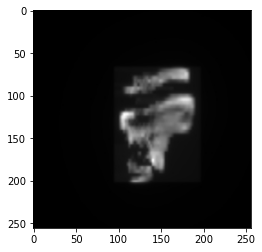

In [39]:
row = train_maps.iloc[0,:]
path = row['full_filename_jpeg']
im = read_image(path)
plt.imshow(im)

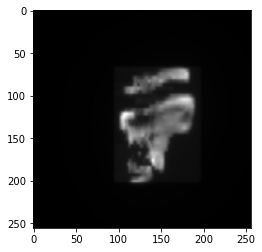

In [40]:
x = np.rollaxis(x, 2)
x = np.rollaxis(x, 2)
plt.imshow(x)

In [41]:
x, y, _ = valid_ds[0]
x.shape, y

((3, 256, 256), array([99.968552]))

In [42]:
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=8)

In [43]:
len(train_ds)

982

In [44]:
len(train_loader)

31

In [45]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

## Model

In [46]:
#conda install ipywidgets
resnet = models.resnet18(pretrained=True)
# resnet 

In [47]:
layers = list(resnet.children())
print(len(layers))
# layers[-2:]
for i in range(len(layers)):
    print (f"-----------------------layer {i}-----------------------")
    print(layers[i])
    
# we want to freeze the fc2 layer this time: only train fc1 and fc3
#net.fc2.weight.requires_grad = False
#net.fc2.bias.requires_grad = False

#for param in resnet.parameters():
#    param.requires_grad = True
    
#layers[0].weight.requires_grad = False
#layers[1].requires_grad = False
#layers[4][0].conv1.weight.requires_grad = False
#layers[4][0].conv2.weight.requires_grad = False

#for param in resnet.parameters():
#    print(param.shape, param.requires_grad)

10
-----------------------layer 0-----------------------
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-----------------------layer 1-----------------------
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-----------------------layer 2-----------------------
ReLU(inplace=True)
-----------------------layer 3-----------------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-----------------------layer 4-----------------------
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64,

In [48]:
# see https://discuss.pytorch.org/t/pytorch-equivalent-of-keras/29412
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.out = 512 + 512 # for resnet18 and resnet34
        #self.out = 2048 + 2048 # for resnet50
        self.bn1 = nn.BatchNorm1d(self.out)
        self.fc1 = nn.Linear(self.out, 512)
        #self.fc1 = nn.Linear(self.out, 2048)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512,1))
        #self.classifier = nn.Sequential(nn.BatchNorm1d(2048), nn.Linear(2048,1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x1 = nn.AdaptiveAvgPool2d((1,1))(x)
        x1 = x1.view(x1.shape[0], -1) # flattening
        x2 = nn.AdaptiveMaxPool2d((1,1))(x)
        x2 = x2.view(x2.shape[0], -1) # flattening
        x = torch.cat([x1, x2], 1)
        x = nn.Dropout(0.2)(x) # hace falta dropout caso contrario se observa overfitting, y entre [0.2, 0.5] está OK.
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x) # idem anterior
        x = self.classifier(x)
        return x

In [49]:
model = Net().cuda()

In [50]:
model

Net(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [51]:
x, y, _ = next(iter(train_dl))

In [52]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([32, 3, 256, 256])

In [53]:
x_features = model.features1(x)
x_features.shape

torch.Size([32, 128, 32, 32])

In [54]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([32, 512, 8, 8])

In [55]:
x_features2 = F.relu(x_features2)

In [56]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features2)
x_features_ave.shape

torch.Size([32, 512, 1, 1])

In [57]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([32, 512])

In [58]:
y_hat = model(x)
y_hat.shape

torch.Size([32, 1])

In [59]:
# L1Loss (MAE), see https://pytorch.org/docs/master/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
F.l1_loss(y_hat, y)

tensor(99.5446, device='cuda:0', grad_fn=<L1LossBackward>)

In [60]:
y.shape

torch.Size([32, 1])

In [61]:
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False
#    
#for param in model.parameters():
#    print(param.requires_grad)

In [62]:
del y_hat
del x_features_flatten
del x_features_ave
del x_features2
del x_features

In [63]:
torch.cuda.empty_cache()

In [64]:
def show_gpu_mem():
    mma=torch.cuda.max_memory_allocated()/1024/1024 # obsolets torch.cuda.max_memory_cached()
    ma=torch.cuda.memory_allocated()/1024/1024
    mmr=torch.cuda.max_memory_reserved()/1024/1024
    mr=torch.cuda.memory_reserved()/1024/1024
    print(f"max. memory alloc.={mma:3.1f}\nmemory alloc.={ma:3.1f}\nmax. memory reserv.={mmr:3.1f}\nmemory reserv.={mr:3.1f}")

In [65]:
show_gpu_mem()

max. memory alloc.=1842.9
memory alloc.=933.4
max. memory reserv.=1856.0
memory reserv.=1024.0


## Checking Loss function
Let's write the loss function from scratch in numpy to check the pytorch function.

## Learning rate finder

From this paper https://arxiv.org/pdf/1506.01186.pdf. This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from 1e-5 to 0.012.

In [66]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    #for param in model.parameters():
    #    print(param.requires_grad)
    return optim.Adam(params, weight_decay=1e-5)
    #return optim.Adam(params, weight_decay=0)
    #return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), weight_decay=1e-5)

    
def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [67]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))


def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=3):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    print(f"train size: {len(train_dl)}, no. iter: {iterations}, lr_high - lr_low: {lr_high - lr_low}, delta: {delta:.3e}")
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    ind = 0
    for i in range(epochs):
        for x, y, _ in train_dl:
            lr = lrs[ind]
            # print(f"lr: {lr}")
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses    

In [68]:
# >>> create model >>>
model = Net().cuda()
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False

lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1.0, epochs=5)

train size: 31, no. iter: 155, lr_high - lr_low: 0.99999, delta: 6.452e-03


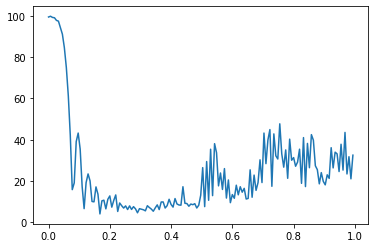

In [69]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [70]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    # print(f"i: {i}, c_i: {c_i}, res: {end_lr + (start_lr - end_lr)/2 *c_i}")
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    print(f"min_start: {min_start:.3e}, min_end: {min_end:.3e}, iter1: {iter1}, iter2: {iter2}")
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

min_start: 1.200e-03, min_end: 1.200e-07, iter1: 600, iter2: 1400


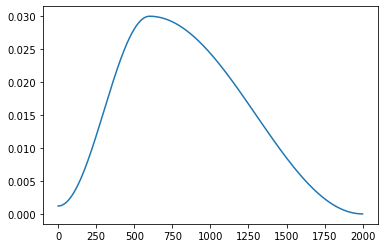

In [71]:
N = 2000
lr = get_cosine_triangular_lr(0.03, N)
plt.plot(list(range(N)), lr)
plt.show()

In [72]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y, _ in train_dl:
        lr = lrs[idx]
        # print(f"lr: {lr}")
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.l1_loss(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [73]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            if val_loss < 1.0: # only save model file if val MAE < 1.0
                path = "{0}/models/model_resnet18_{1:.3f}.pth".format(PATH, val_loss)
                save_model(model, path)
                print(path)

In [74]:
# changed for regression
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for x, y, _ in valid_dl:
            # x and y are tensors, x.shape is [64, 3, 256, 256] and y.shape is [64, 1]
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x) # out is a tensor with shape [64, 1]
            y = y.float()
            loss = F.l1_loss(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total

## Training with triangular rates

In [75]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [76]:
model = Net().cuda()

In [77]:
val_metrics(model, valid_dl)

100.63918575163811

In [78]:
MAX_LR = 0.03

In [ ]:
# create models directory under /home/pablo/datasets/data/invasive-species-monitoring/ first time
# same for /home/pablo/datasets/data/radioterapia/ciolaplata/models/
model = Net().cuda()
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 5)

In [ ]:
model = Net().cuda()

# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = True

#for param in model.features2.parameters():
#    param.requires_grad = True
    
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 10)

In [ ]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 20)

In [79]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 80)

min_start: 1.200e-03, min_end: 1.200e-07, iter1: 744, iter2: 1736
train_loss 99.111 val_loss 97.422
train_loss 96.167 val_loss 93.268
train_loss 86.411 val_loss 81.006
train_loss 59.641 val_loss 36.957
train_loss 13.077 val_loss 147.902
train_loss 5.279 val_loss 4.083
train_loss 4.648 val_loss 3.432
train_loss 4.020 val_loss 13.402
train_loss 3.573 val_loss 2.659
train_loss 3.123 val_loss 4.706
train_loss 2.910 val_loss 2.656
train_loss 2.320 val_loss 1.866
train_loss 2.209 val_loss 1.334
train_loss 1.645 val_loss 4.208
train_loss 1.360 val_loss 0.998
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.998.pth
train_loss 1.299 val_loss 0.792
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.792.pth
train_loss 1.571 val_loss 1.290
train_loss 1.346 val_loss 1.913
train_loss 1.446 val_loss 1.318
train_loss 1.250 val_loss 0.544
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.544.pth
train_loss 1.165 val_loss 0.763
trai

In [80]:
show_gpu_mem()

max. memory alloc.=2064.2
memory alloc.=1024.5
max. memory reserv.=2330.0
memory reserv.=2330.0


## Load a model

In [ ]:
def get_predictions_df(model, valid_dl):
    model.eval()
    pred = []
    with torch.no_grad():
        for x, y, file in valid_dl:
            # x and y are tensors, x.shape is [BATCH_SIZE, 3, 256, 256] and y.shape is [BATCH_SIZE, 1]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x) # out is a tensor with shape [BATCH_SIZE, 1]
            # a.cpu().numpy() == float(a.cpu().numpy())
            batch_pred = [(Path(f).name, a.cpu().item(), b.cpu().item()) for f, a, b in zip(file, y, out)]
            pred = pred + batch_pred
    # build a pandas dataframe with results
    df = pd.DataFrame(pred, columns=['filename', 'actual gamma', 'predicted gamma'])
    return df

In [ ]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [ ]:
# load model
mae = 0.187
mae = 0.219
model = Net().cuda()
p = PATH/"models/model_resnet18_{}.pth".format(mae)
load_model(model, p)

In [ ]:
val_metrics(model, train_dl)

In [ ]:
val_metrics(model, valid_dl)

In [ ]:
part = "training" # training or validation
if part == "validation":
    df = get_predictions_df(model, valid_dl)
else:
    df = get_predictions_df(model, train_dl)            
df.head()

In [ ]:
p = PATH/"predictions/model_resnet18_{}_{}.csv".format(mae, part)
df.to_csv(p, index=False)

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions. This usually helps but here our accuracy is too high.

_Pablo: Since we are not doing data augmentation for fluence maps, then testing time augmentation neithe applies_

## Lab
Can you get better accuracy?
* Change some of the hyperparameters (add dropout, increase the number of the hidden units)
* Increase the image resolution
* Modify the data augmentation to include other transformations

# References
This notebook is based on https://github.com/yanneta/deep-learning-data-institute/blob/master/lesson5-image-cnn.ipynb from course "Fundamentals of Deep Learning with Pytorch"